In [ ]:
# Section 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import plotly.graph_objects as go
from google.colab import files

In [ ]:
uploaded = files.upload()  # Upload your CSV file here, e.g., 'health_env_data.csv'
file_name = list(uploaded.keys())[0]
print(f"Uploaded file: {file_name}")

Saving health_env_ml_training_data.csv to health_env_ml_training_data.csv
Uploaded file: health_env_ml_training_data.csv


In [ ]:
df = pd.read_csv(file_name, parse_dates=True)
print("Dataset sample:")
print(df.head())


Dataset sample:
                    Timestamp  Env_Temp  Humidity     AQI  PM2.5  HeartRate  \
0  2025-04-26 16:20:18.608246     25.21     57.32  135.19  64.99      70.69   
1  2025-04-26 16:25:18.608246     23.24     73.23  100.51  61.53      70.56   
2  2025-04-26 16:30:18.608246     22.08     61.76  123.90  34.79      66.66   
3  2025-04-26 16:35:18.608246     32.06     49.75  121.54  71.21      70.18   
4  2025-04-26 16:40:18.608246     28.93     78.48  116.17  42.84      77.22   

    SpO2  BP_Systolic  BP_Diastolic  Stress_Level  
0  98.02       116.18         81.23          7.42  
1  97.92       116.37         76.83          5.26  
2  98.03       117.74         76.67          2.97  
3  97.49       117.45         82.52          6.52  
4  98.49       121.13         81.41          3.81  


In [ ]:
# Section 4: Select relevant columns based on your features
features = ['Env_Temp', 'Humidity', 'AQI', 'PM2.5', 'HeartRate', 'SpO2', 'Stress_Level', 'BP_Systolic', 'BP_Diastolic']
df = df[features].dropna()
print(f"Using features: {features}")

Using features: ['Env_Temp', 'Humidity', 'AQI', 'PM2.5', 'HeartRate', 'SpO2', 'Stress_Level', 'BP_Systolic', 'BP_Diastolic']


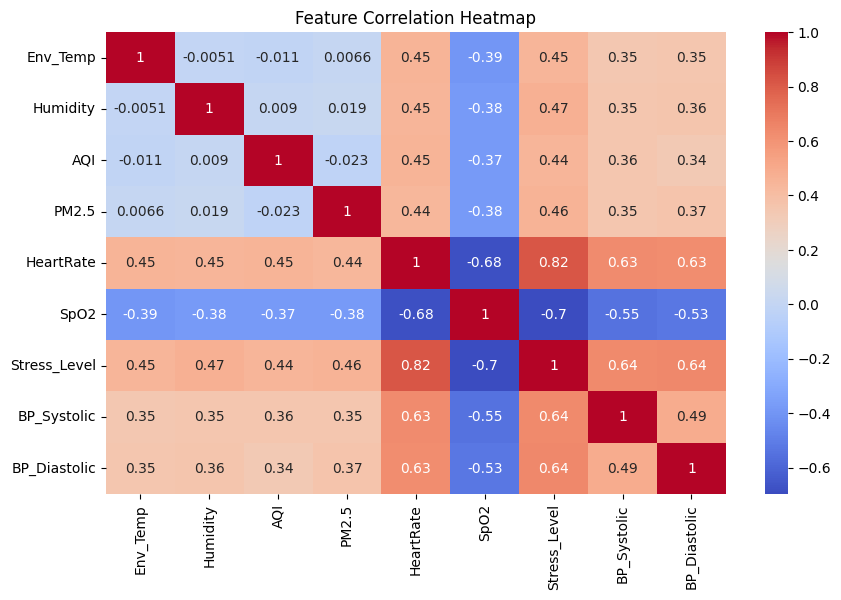

In [ ]:
# Section 5: Visualize correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:

# Section 6: Normalize data using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)


In [ ]:

# Save scaler for later use in deployment
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")


Scaler saved as 'scaler.pkl'


In [ ]:

# Section 7: Create sequences for time series forecasting
def create_sequences(data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

look_back = 10
X, y = create_sequences(data_scaled, look_back)
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

Shape of X: (4990, 10, 9), Shape of y: (4990, 9)


In [ ]:
# Section 8: Train-test split (no shuffling to keep temporal order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Train samples: 3992, Test samples: 998


In [ ]:
# Section 9: Build LSTM model for multi-feature prediction
model = Sequential([
    LSTM(128, input_shape=(look_back, len(features)), return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(len(features))  # output layer predicts all features (environment + vitals)
])
model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,649 (471.29 KB)

 Trainable params: 120,649 (471.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Section 10: Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0794 - val_loss: 0.0262
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0318 - val_loss: 0.0259
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0298 - val_loss: 0.0266
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0286 - val_loss: 0.0261
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0280 - val_loss: 0.0265
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0289 - val_loss: 0.0263
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0269 - val_loss: 0.0262
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0267 - val_loss: 0.0257
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0275 - val_loss: 0.0257
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0269 - val_loss: 0.0274
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0266 - val_loss: 0.0262
Epoch 12/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Save the trained model
model.save('health_env_lstm_model.keras')  # Save in Keras format

print("Model saved as health_env_lstm_model.keras")


Model saved as health_env_lstm_model.keras


In [ ]:
# Section 11: Predict on test set
predictions = model.predict(X_test)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [ ]:

# Inverse transform to get real values back
predicted_actual = scaler.inverse_transform(predictions)
y_actual = scaler.inverse_transform(y_test)

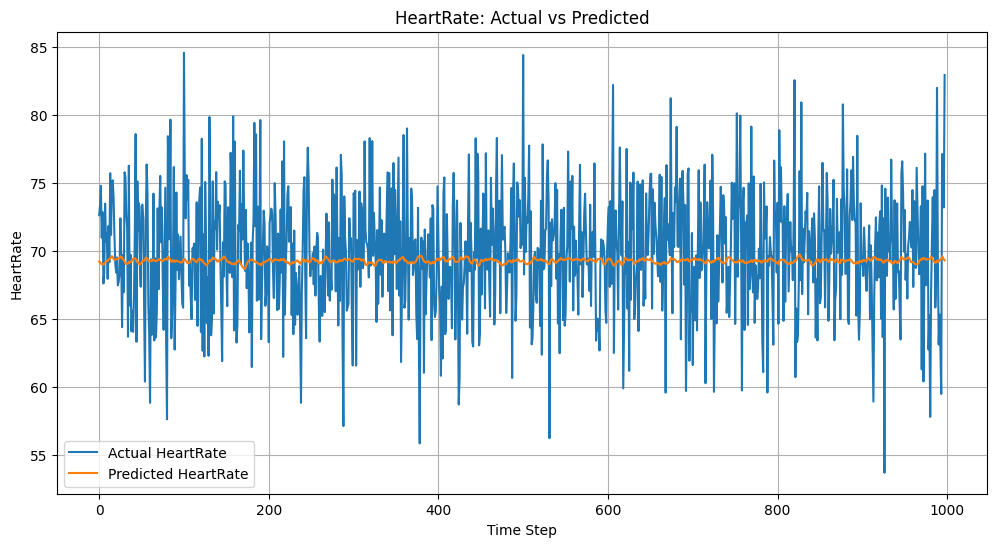

In [ ]:

# Plot actual vs predicted for key vitals: HeartRate and SpO2 as example
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:, features.index('HeartRate')], label='Actual HeartRate')
plt.plot(predicted_actual[:, features.index('HeartRate')], label='Predicted HeartRate')
plt.title('HeartRate: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('HeartRate')
plt.legend()
plt.grid()
plt.show()

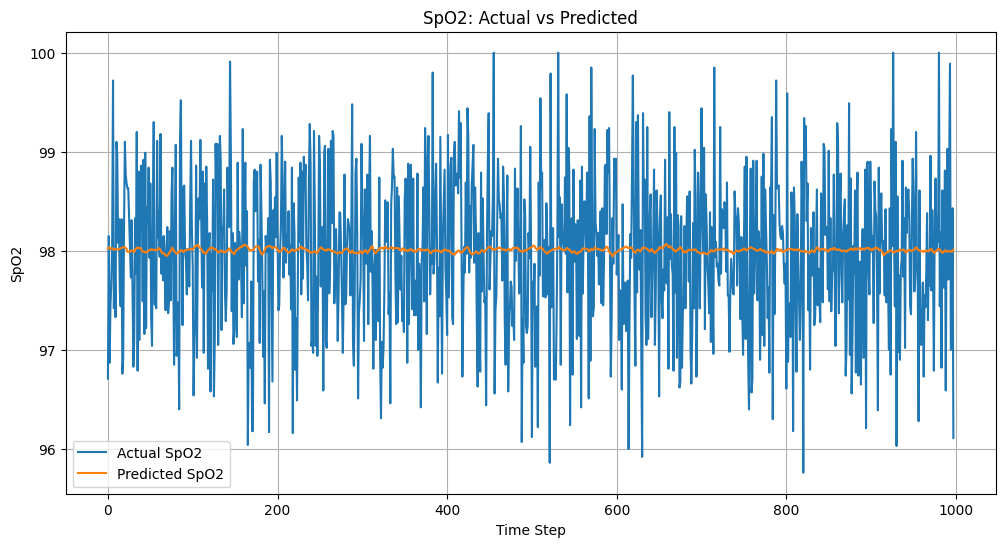

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:, features.index('SpO2')], label='Actual SpO2')
plt.plot(predicted_actual[:, features.index('SpO2')], label='Predicted SpO2')
plt.title('SpO2: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('SpO2')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Section 12: Predict future single step (based on last test input)
last_input = X_test[-1].reshape(1, look_back, len(features))
predicted_future = model.predict(last_input)
pred_future_actual = scaler.inverse_transform(predicted_future)[0]
print("Predicted future health + env parameters:")
for f, val in zip(features, pred_future_actual):
    print(f"{f}: {val:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted future health + env parameters:
Env_Temp: 29.17
Humidity: 58.88
AQI: 96.34
PM2.5: 59.87
HeartRate: 69.29
SpO2: 98.01
Stress_Level: 4.73
BP_Systolic: 119.41
BP_Diastolic: 79.60


In [ ]:

# Section 13: Health Risk Score Calculation & Speedometer Visualization
# Define a custom risk scoring based on predicted future vitals + env parameters

def compute_health_score(pred):
    score = 100

    # Example heuristics - customize as needed
    hr = pred[features.index('HeartRate')]
    spo2 = pred[features.index('SpO2')]
    pm25 = pred[features.index('PM2.5')]
    aqi = pred[features.index('AQI')]
    temp = pred[features.index('Env_Temp')]
    stress = pred[features.index('Stress_Level')]
    bp_sys = pred[features.index('BP_Systolic')]
    bp_dia = pred[features.index('BP_Diastolic')]

    # Heart Rate normal range approx 60-100
    if hr > 100 or hr < 60:
        score -= 20
    # SpO2 should be > 95%
    if spo2 < 95:
        score -= 20
    # PM2.5 safe level < 35 (based on US EPA standards)
    if pm25 > 35:
        score -= 15
    # AQI good < 50, moderate < 100, unhealthy > 150
    if aqi > 150:
        score -= 20
    elif aqi > 100:
        score -= 10
    # Temp normal range ~36.5-37.5 Celsius
    if temp > 37.5 or temp < 35:
        score -= 10
    # Stress level (assuming scale 0-100), high stress penalizes
    if stress > 70:
        score -= 10
    # Blood Pressure normal: systolic < 120, diastolic < 80
    if bp_sys > 140 or bp_dia > 90:
        score -= 15
    elif bp_sys > 120 or bp_dia > 80:
        score -= 5

    # Clamp score between 0 and 100
    score = max(0, min(100, score))
    return score

score = compute_health_score(pred_future_actual)

# Classify based on score
if score > 90:
    status = "Excellent"
    risk = "No significant health risk predicted."
elif score > 75:
    status = "Good"
    risk = "Minor issues possible. Maintain healthy lifestyle."
elif score > 55:
    status = "Moderate"
    risk = "Monitor your vitals regularly; risk of mild conditions."
elif score > 35:
    status = "Poor"
    risk = "Warning: Elevated risk of chronic diseases."
else:
    status = "Critical"
    risk = "High risk of severe health complications. Consult a physician."

print(f"\n🩺 Predicted Health Status: {status}")
print(f"⚠️ Risk Insight: {risk}")


🩺 Predicted Health Status: Moderate
⚠️ Risk Insight: Monitor your vitals regularly; risk of mild conditions.


In [ ]:
# Plot Speedometer Gauge using Plotly
fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=score,
    title={'text': "Future Health Condition Score"},
    gauge={
        'axis': {'range': [0, 100]},
        'steps': [
            {'range': [0, 35], 'color': "red"},
            {'range': [35, 55], 'color': "orange"},
            {'range': [55, 75], 'color': "yellow"},
            {'range': [75, 90], 'color': "lightgreen"},
            {'range': [90, 100], 'color': "green"},
        ],
        'threshold': {
            'line': {'color': "black", 'width': 4},
            'thickness': 0.75,
            'value': score
        }
    }
))
fig.show()


In [ ]:
#Real time data analyzies
import pandas as pd

# Replace with your actual Channel ID
channel_id = "2973452"
read_api_key = "7QFWLIC9B253BSSA"

# Fetch last 5 entries from ThingSpeak as CSV
url = f"https://api.thingspeak.com/channels/{channel_id}/feeds.csv?api_key={read_api_key}&results=5"

# Read into DataFrame
df = pd.read_csv(url)
df


,created_at,entry_id,field1,field2,field3,field4,field5,field6,field7
0,2025-05-28 10:25:14 UTC,222,83.99,96.0,223.23,1,0,160.6,95.2
1,2025-05-28 10:25:36 UTC,223,83.99,96.0,223.23,1,0,160.6,95.2
2,2025-05-28 10:25:58 UTC,224,83.99,96.0,223.23,1,0,160.6,95.2
3,2025-05-28 10:26:57 UTC,225,88.83,95.0,3076.64,1,0,162.9,96.6
4,2025-05-28 10:27:19 UTC,226,88.83,95.0,3076.64,1,0,162.9,96.6


In [ ]:
from datetime import datetime
import time

# Extract the latest 'created_at' datetime string from the last row (most recent)
# Assuming the 'created_at' column has the date/time info
dt_str = df['created_at'].iloc[-1]  # last row's created_at

print(f"Latest datetime string from ThingSpeak: {dt_str}")

# Convert to datetime object
# The format from ThingSpeak usually looks like: '2025-05-27 19:22:29 UTC'
dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S %Z")

# Convert to Unix timestamp (UTC)
unix_time = int(time.mktime(dt_obj.timetuple()))


print(f"Unix timestamp: {unix_time}")

Latest datetime string from ThingSpeak: 2025-05-28 10:27:19 UTC
Unix timestamp: 1748428039


In [ ]:
import requests
from datetime import datetime

# Input
timestamp_str = dt_str
timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S %Z")

latitude = "10.647800371144283"
longitude = "79.04821224553947"

# Format for APIs
date_str = timestamp.strftime("%Y-%m-%d")
hour_index = timestamp.hour  # e.g., 20 for 8 PM

# ==== 1. WEATHER DATA from Visual Crossing ====
vc_api_key = "TWGG4YF68PLHPRPLERWF6MUGM"
weather_url = (
    f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
    f"{latitude},{longitude}/{date_str}?unitGroup=metric&key={vc_api_key}&include=days,hours"
)

weather_response = requests.get(weather_url)
if weather_response.status_code == 200:
    weather_data = weather_response.json()
    hourly_weather = weather_data["days"][0]["hours"][hour_index]
    temp = hourly_weather["temp"]
    humidity = hourly_weather["humidity"]
    print(f"[{timestamp_str}] Temperature:", temp, "°C")
    print(f"[{timestamp_str}] Humidity:", humidity, "%")
else:
    print(f"Weather Error: {weather_response.status_code}, {weather_response.text}")

# ==== 2. AIR QUALITY DATA from Open-Meteo ====
aq_url = (
    f"https://air-quality-api.open-meteo.com/v1/air-quality"
    f"?latitude={latitude}&longitude={longitude}"
    f"&start_date={date_str}&end_date={date_str}"
    f"&hourly=pm2_5,us_aqi"
)

aq_response = requests.get(aq_url)
if aq_response.status_code == 200:
    aq_data = aq_response.json()
    pm25 = aq_data['hourly']['pm2_5'][hour_index]
    aqi = aq_data['hourly']['us_aqi'][hour_index]
    print(f"[{timestamp_str}] PM2.5:", pm25, "µg/m³")
    print(f"[{timestamp_str}] AQI :", aqi)
else:
    print(f"AQI Error: {aq_response.status_code}, {aq_response.text}")


[2025-05-28 10:27:19 UTC] Temperature: 33.0 °C
[2025-05-28 10:27:19 UTC] Humidity: 62.92 %
[2025-05-28 10:27:19 UTC] PM2.5: 4.7 µg/m³
[2025-05-28 10:27:19 UTC] AQI : 32


In [ ]:
import pandas as pd
import requests
from datetime import datetime
import time
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import plotly.graph_objects as go

# --- Step 1: Load live data from ThingSpeak ---

channel_id = "2973452"
read_api_key = "7QFWLIC9B253BSSA"
url = f"https://api.thingspeak.com/channels/{channel_id}/feeds.csv?api_key={read_api_key}&results=5"

df = pd.read_csv(url)

# Check columns & latest row
print("ThingSpeak columns:", df.columns)
last_row = df.iloc[-1]
print("Latest ThingSpeak row:\n", last_row)

# --- Step 2: Parse timestamp from ThingSpeak data ---
dt_str = last_row['created_at']  # Example: '2025-05-27 19:22:29 UTC'
print(f"Latest datetime string from ThingSpeak: {dt_str}")

dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S %Z")
unix_time = int(time.mktime(dt_obj.timetuple()))
print(f"Unix timestamp: {unix_time}")

# --- Step 3: Fetch weather & air quality data using that timestamp & location ---

latitude = "10.647800371144283"
longitude = "79.04821224553947"
date_str = dt_obj.strftime("%Y-%m-%d")
hour_index = dt_obj.hour

# Weather API: Visual Crossing
vc_api_key = "TWGG4YF68PLHPRPLERWF6MUGM"
weather_url = (
    f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
    f"{latitude},{longitude}/{date_str}?unitGroup=metric&key={vc_api_key}&include=days,hours"
)
weather_response = requests.get(weather_url)
if weather_response.status_code == 200:
    weather_data = weather_response.json()
    hourly_weather = weather_data["days"][0]["hours"][hour_index]
    temp = hourly_weather["temp"]
    humidity = hourly_weather["humidity"]
else:
    raise RuntimeError(f"Weather API error: {weather_response.status_code}")

# Air Quality API: Open-Meteo
aq_url = (
    f"https://air-quality-api.open-meteo.com/v1/air-quality"
    f"?latitude={latitude}&longitude={longitude}"
    f"&start_date={date_str}&end_date={date_str}"
    f"&hourly=pm2_5,us_aqi"
)
aq_response = requests.get(aq_url)
if aq_response.status_code == 200:
    aq_data = aq_response.json()
    pm25 = aq_data['hourly']['pm2_5'][hour_index]
    aqi = aq_data['hourly']['us_aqi'][hour_index]
else:
    raise RuntimeError(f"Air Quality API error: {aq_response.status_code}")

print(f"Env data: Temp={temp}, Humidity={humidity}, PM2.5={pm25}, AQI={aqi}")

# --- Step 4: Extract health parameters from ThingSpeak row ---

# Replace 'field1'...'field5' with your actual field names from ThingSpeak CSV
# For example, if columns are exactly 'field1','field2', etc, keep as is.
# If the column headers are different, update accordingly.

heart_rate = last_row['field1']
spo2 = last_row['field2']
stress_level = last_row['field3']
bp_systolic = last_row['field4']
bp_diastolic = last_row['field5']

# --- Step 5: Prepare features vector for prediction ---

# Your features order must exactly match model training feature order:
features = ['Env_Temp', 'Env_Humidity', 'AQI', 'PM2.5', 'HeartRate', 'SpO2', 'Stress_Level', 'BP_Systolic', 'BP_Diastolic']

data_row = [temp, humidity, aqi, pm25, heart_rate, spo2, stress_level, bp_systolic, bp_diastolic]

print("Feature vector before scaling:", data_row)

# --- Step 6: Load scaler and model ---

scaler = joblib.load('scaler.pkl')
model = load_model('health_env_lstm_model.keras')

# --- Step 7: Scale and reshape input for LSTM ---

data_scaled = scaler.transform([data_row])  # shape (1, features)

# LSTM input shape: (samples, timesteps, features)
# Assuming your model expects a sequence length, but here only one timestep
data_scaled_seq = data_scaled.reshape((1, 1, len(features)))

# --- Step 8: Predict future health parameters ---

pred_scaled = model.predict(data_scaled_seq)

# Inverse scale predicted output
pred = scaler.inverse_transform(pred_scaled)[0]

print("Predicted future vitals + env parameters:", pred)

# --- Step 9: Compute health score (reuse your heuristic function) ---

def compute_health_score(pred):
    score = 100

    hr = pred[features.index('HeartRate')]
    spo2 = pred[features.index('SpO2')]
    pm25 = pred[features.index('PM2.5')]
    aqi = pred[features.index('AQI')]
    temp = pred[features.index('Env_Temp')]
    stress = pred[features.index('Stress_Level')]
    bp_sys = pred[features.index('BP_Systolic')]
    bp_dia = pred[features.index('BP_Diastolic')]

    if hr > 100 or hr < 60:
        score -= 20
    if spo2 < 95:
        score -= 20
    if pm25 > 35:
        score -= 15
    if aqi > 150:
        score -= 20
    elif aqi > 100:
        score -= 10
    if temp > 37.5 or temp < 35:
        score -= 10
    if stress > 70:
        score -= 10
    if bp_sys > 140 or bp_dia > 90:
        score -= 15
    elif bp_sys > 120 or bp_dia > 80:
        score -= 5

    score = max(0, min(100, score))
    return score

score = compute_health_score(pred)

# --- Step 10: Classify and print results ---

if score > 90:
    status = "Excellent"
    risk = "No significant health risk predicted."
elif score > 75:
    status = "Good"
    risk = "Minor issues possible. Maintain healthy lifestyle."
elif score > 55:
    status = "Moderate"
    risk = "Monitor your vitals regularly; risk of mild conditions."
elif score > 35:
    status = "Poor"
    risk = "Warning: Elevated risk of chronic diseases."
else:
    status = "Critical"
    risk = "High risk of severe health complications. Consult a physician."

print(f"\n🩺 Predicted Health Status: {status}")
print(f"⚠️ Risk Insight: {risk}")

# --- Step 11: Plot Speedometer Gauge ---

fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=score,
    title={'text': "Future Health Condition Score"},
    gauge={
        'axis': {'range': [0, 100]},
        'steps': [
            {'range': [0, 35], 'color': "red"},
            {'range': [35, 55], 'color': "orange"},
            {'range': [55, 75], 'color': "yellow"},
            {'range': [75, 90], 'color': "lightgreen"},
            {'range': [90, 100], 'color': "green"},
        ],
        'threshold': {
            'line': {'color': "black", 'width': 4},
            'thickness': 0.75,
            'value': score
        }
    }
))
fig.show()


ThingSpeak columns: Index(['created_at', 'entry_id', 'field1', 'field2', 'field3', 'field4',
       'field5', 'field6', 'field7'],
      dtype='object')
Latest ThingSpeak row:
 created_at    2025-05-28 10:22:59 UTC
entry_id                          219
field1                          94.36
field2                           96.0
field3                        1388.54
field4                              1
field5                              0
field6                          165.8
field7                           98.3
Name: 4, dtype: object
Latest datetime string from ThingSpeak: 2025-05-28 10:22:59 UTC
Unix timestamp: 1748427779
Env data: Temp=33.0, Humidity=62.92, PM2.5=4.7, AQI=32
Feature vector before scaling: [33.0, 62.92, 32, 4.7, np.float64(94.36), np.float64(96.0), np.float64(1388.54), np.int64(1), np.int64(0)]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
Predicted future vitals + env parameters: [ 24.148499   50.598274   68.29111    46.41933    65.193      97.156975
   3.2465024 115.38223    76.82518  ]

🩺 Predicted Health Status: Moderate
⚠️ Risk Insight: Monitor your vitals regularly; risk of mild conditions.


In [ ]:
import requests

# Your dynamic variables (these can come from your model or sensor data)
predicted_health_status = "Moderate"
risk_insight = "Monitor your vitals regularly; risk of mild conditions."

# OpenRouter API key and headers
API_KEY = "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"  # keep secret
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json",
    "HTTP-Referer": "https://yourdomain.com",
    "X-Title": "health-lifestyle-recommender"
}

# Compose the dynamic prompt
user_message = f"""Based on this health status, give personalized lifestyle recommendations:
Predicted Health Status: {predicted_health_status}
⚠️ Risk Insight: {risk_insight}"""

# API endpoint and payload
url = "https://openrouter.ai/api/v1/chat/completions"
data = {
    "model": "mistralai/mistral-7b-instruct:free",
    "messages": [
        {"role": "system", "content": "You are a health assistant that gives lifestyle recommendations."},
        {"role": "user", "content": user_message}
    ]
}

# Send request
response = requests.post(url, headers=headers, json=data)

# Handle response
if response.status_code == 200:
    print(response.json()["choices"][0]["message"]["content"])
else:
    print("Error:", response.status_code, response.text)


 Based on your predicted health status as "Moderate" with a mild risk insight, here are some personalized lifestyle recommendations to help maintain your health:

1. Regular Check-ups: Continue to monitor your vitals regularly to keep track of any changes or deterioration in your health. This can include blood pressure, blood sugar, cholesterol levels, and weight.

2. Balanced Diet: Maintain a balanced diet with an appropriate amount of fruits, vegetables, lean proteins, whole grains, and healthy fats. Try to limit sugary, processed, and high-salt foods.

3. Adequate Hydration: Drink plenty of water throughout the day to keep yourself hydrated. Aim for at least 8 glasses a day, and more if you're physically active or live in a hot climate.

4. Regular Exercise: Engage in moderate physical activity for at least 30 minutes per day, five days a week. This can be anything from walking, cycling, swimming, to yoga or any other activity that gets your heart rate up.

5. Stress Management: Hig